# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [79]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.dummy import DummyClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [80]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [81]:
default_seed = 1
output_file = "output_sample"

In [82]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [83]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [84]:
print(discrete_features)
print(continuous_features)
print(ret_cols)

['home_ownership', 'delinq_2yrs', 'term', 'purpose', 'pub_rec', 'grade', 'verification_status', 'emp_length']
['loan_amnt', 'funded_amnt', 'installment', 'annual_inc', 'dti', 'open_acc', 'fico_range_high', 'fico_range_low', 'revol_bal', 'int_rate', 'revol_util']
['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']


In [85]:
print(data.head())
print(data.shape)
print(type(data))
data.head()

        id  loan_amnt  funded_amnt        term  int_rate  installment grade  \
0  1077501       5000         5000   36 months     10.65       162.87     B   
1  1077430       2500         2500   60 months     15.27        59.83     C   
2  1077175       2400         2400   36 months     15.96        84.33     C   
3  1076863      10000        10000   36 months     13.49       339.31     C   
4  1075358       3000         3000   60 months     12.69        67.79     B   

  emp_length home_ownership  annual_inc    ...    revol_util   total_pymnt  \
0  10+ years           RENT     24000.0    ...          83.7   5863.155187   
1   < 1 year           RENT     30000.0    ...           9.4   1014.530000   
2  10+ years           RENT     12252.0    ...          98.5   3005.666844   
3  10+ years           RENT     49200.0    ...          21.0  12231.890000   
4     1 year           RENT     80000.0    ...          53.9   4066.908161   

  last_pymnt_d recoveries  loan_length term_num  ret_PES

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,revol_util,total_pymnt,last_pymnt_d,recoveries,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb
0,1077501,5000,5000,36 months,10.65,162.87,B,10+ years,RENT,24000.0,...,83.7,5863.155187,2015-01-01,0.0,37.027454,36,0.057544,0.055988,0.054598,0.088129
1,1077430,2500,2500,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,...,9.4,1014.530000,2013-04-01,122.9,16.000329,60,-0.118838,-0.118838,-0.110200,-0.095511
2,1077175,2400,2400,36 months,15.96,84.33,C,10+ years,RENT,12252.0,...,98.5,3005.666844,2014-06-01,0.0,29.996509,36,0.084120,0.100944,0.073804,0.113010
3,1076863,10000,10000,36 months,13.49,339.31,C,10+ years,RENT,49200.0,...,21.0,12231.890000,2015-01-01,0.0,37.027454,36,0.074396,0.072386,0.065575,0.100551
4,1075358,3000,3000,60 months,12.69,67.79,B,1 year,RENT,80000.0,...,53.9,4066.908161,2017-01-01,0.0,61.044375,60,0.071127,0.069961,0.087466,0.114497


In [86]:
data.columns
print(type(data['issue_d']))

<class 'pandas.core.series.Series'>


In [87]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = np.where(np.logical_or(data['loan_status'] == 'Charged Off',data['loan_status'] == 'Default'),True,False)
#data["outcome"] = np.where(data['loan_status'] == 'Charged Off',True,False)

In [88]:
data.head()
print(len(data['outcome']==True))
print(len(data['outcome']==False))

798242
798242


In [89]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [90]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
n = int(0.7*(data.shape[0]))
print(data.shape[0])
print(n)
data2 = np.random.choice(data.shape[0],n)
print(type(data2))
print(data2.shape)
data['train'] = [True if idx in data2 else False for idx in range(data.shape[0])]
#data['train']


798242
558769
<class 'numpy.ndarray'>
(558769,)


In [91]:
data.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,recoveries,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,outcome,cr_hist,train
0,1077501,5000,5000,36 months,10.65,162.87,B,10+ years,RENT,24000.0,...,0.0,37.027454,36,0.057544,0.055988,0.054598,0.088129,False,322.963511,False
1,1077430,2500,2500,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,...,122.9,16.000329,60,-0.118838,-0.118838,-0.110200,-0.095511,True,152.019549,True
2,1077175,2400,2400,36 months,15.96,84.33,C,10+ years,RENT,12252.0,...,0.0,29.996509,36,0.084120,0.100944,0.073804,0.113010,False,120.971683,False
3,1076863,10000,10000,36 months,13.49,339.31,C,10+ years,RENT,49200.0,...,0.0,37.027454,36,0.074396,0.072386,0.065575,0.100551,False,189.966940,False
4,1075358,3000,3000,60 months,12.69,67.79,B,1 year,RENT,80000.0,...,0.0,61.044375,60,0.071127,0.069961,0.087466,0.114497,False,190.985441,True


In [92]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

In [93]:
print(X_continuous.shape)
print(X_discrete.shape)
print(len(continuous_features))
print(continuous_features)
print(discrete_features_dummies)

(798242, 12)
(798242, 101)
12
['loan_amnt', 'funded_amnt', 'installment', 'annual_inc', 'dti', 'open_acc', 'fico_range_high', 'fico_range_low', 'revol_bal', 'int_rate', 'revol_util', 'cr_hist']
['home_ownership::MORTGAGE', 'home_ownership::NONE', 'home_ownership::OTHER', 'home_ownership::OWN', 'home_ownership::RENT', 'home_ownership::nan', 'delinq_2yrs::1', 'delinq_2yrs::10', 'delinq_2yrs::11', 'delinq_2yrs::12', 'delinq_2yrs::13', 'delinq_2yrs::14', 'delinq_2yrs::15', 'delinq_2yrs::16', 'delinq_2yrs::17', 'delinq_2yrs::18', 'delinq_2yrs::19', 'delinq_2yrs::2', 'delinq_2yrs::20', 'delinq_2yrs::21', 'delinq_2yrs::22', 'delinq_2yrs::24', 'delinq_2yrs::25', 'delinq_2yrs::26', 'delinq_2yrs::3', 'delinq_2yrs::30', 'delinq_2yrs::39', 'delinq_2yrs::4', 'delinq_2yrs::5', 'delinq_2yrs::6', 'delinq_2yrs::7', 'delinq_2yrs::8', 'delinq_2yrs::9', 'delinq_2yrs::nan', 'term:: 60 months', 'term::nan', 'purpose::credit_card', 'purpose::debt_consolidation', 'purpose::educational', 'purpose::home_improve

## Prepare functions to fit and evaluate models

In [97]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    print( data_subset)
    print(train)
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    print(lter_train.count)
    print(len(filter_test))
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [95]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters,n_jobs=-1)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [96]:
## define your set of features to use in different models
your_features = continuous_features+discrete_features_dummies+ret_cols
# prepare the train, test data for training models
print(your_features)
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

['loan_amnt', 'funded_amnt', 'installment', 'annual_inc', 'dti', 'open_acc', 'fico_range_high', 'fico_range_low', 'revol_bal', 'int_rate', 'revol_util', 'cr_hist', 'home_ownership::MORTGAGE', 'home_ownership::NONE', 'home_ownership::OTHER', 'home_ownership::OWN', 'home_ownership::RENT', 'home_ownership::nan', 'delinq_2yrs::1', 'delinq_2yrs::10', 'delinq_2yrs::11', 'delinq_2yrs::12', 'delinq_2yrs::13', 'delinq_2yrs::14', 'delinq_2yrs::15', 'delinq_2yrs::16', 'delinq_2yrs::17', 'delinq_2yrs::18', 'delinq_2yrs::19', 'delinq_2yrs::2', 'delinq_2yrs::20', 'delinq_2yrs::21', 'delinq_2yrs::22', 'delinq_2yrs::24', 'delinq_2yrs::25', 'delinq_2yrs::26', 'delinq_2yrs::3', 'delinq_2yrs::30', 'delinq_2yrs::39', 'delinq_2yrs::4', 'delinq_2yrs::5', 'delinq_2yrs::6', 'delinq_2yrs::7', 'delinq_2yrs::8', 'delinq_2yrs::9', 'delinq_2yrs::nan', 'term:: 60 months', 'term::nan', 'purpose::credit_card', 'purpose::debt_consolidation', 'purpose::educational', 'purpose::home_improvement', 'purpose::house', 'purpo

In [64]:
def fit_classification_random(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------
    dummy = DummyClassifier()
    start_time = time.time()
    dummy.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = dummy
    
    """
    cv_model = GridSearchCV(model, cv_parameters,n_jobs=-1)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    """
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        #print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        #print("Optimal parameters:")
        #print(dummy.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
            
            
    print(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
    
    out = {'model':best_model, 'y_pred_labels':y_pred}
    # Dump the AUC to file
    dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
    
    """
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(dummy)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(dummy)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(dummy.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        """
    
    
        
    return out

  Model: Random Classifier

Accuracy-maximizing threshold was: 1
Accuracy:  0.7971
              precision    recall  f1-score   support

  No default     0.7971    1.0000    0.8871     15942
     Default     0.0000    0.0000    0.0000      4058

   micro avg     0.7971    0.7971    0.7971     20000
   macro avg     0.3986    0.5000    0.4435     20000
weighted avg     0.6354    0.7971    0.7071     20000



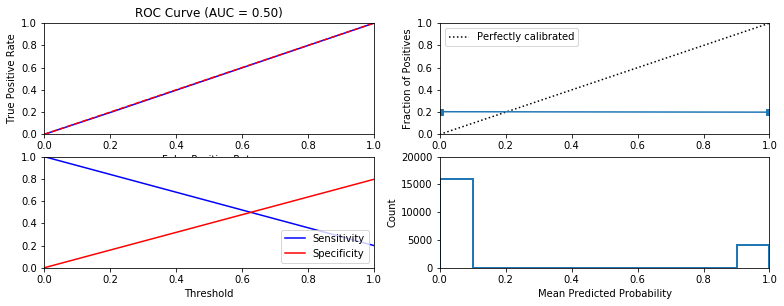


Similarity to LC grade ranking:  0.0031757060242893803
Brier score: 0.32515
Random Classifier::roc_auc 0.49808143542025396


In [20]:
dummy = DummyClassifier()
dummy = fit_classification_random(model=dummy, data_dict=data_dict,cv_parameters={},model_name='Random Classifier')

### Naive Bayes

  Model: Naive Bayes
Fit time: 1.13 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.8781213504035784
Accuracy:  0.80065
              precision    recall  f1-score   support

  No default     0.8021    0.9956    0.8884     15942
     Default     0.6682    0.0347    0.0661      4058

   micro avg     0.8006    0.8006    0.8006     20000
   macro avg     0.7352    0.5152    0.4772     20000
weighted avg     0.7749    0.8006    0.7216     20000



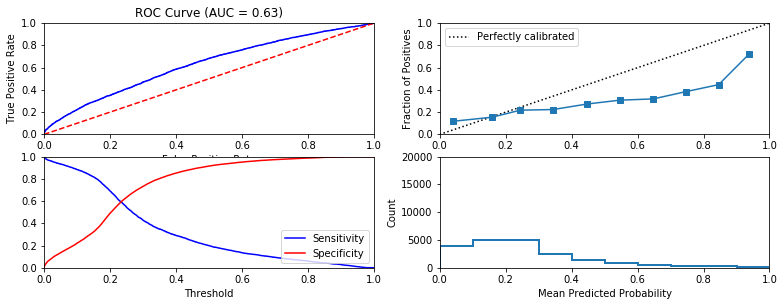


Similarity to LC grade ranking:  0.3047900883475679
Brier score: 0.17040132828055388
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.76406667]


In [22]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(model=gnb, data_dict=data_dict,
                          cv_parameters = {},
                          model_name = 'Naive Bayes')

### $l_1$ regularized logistic regression

  Model: L1 regularized Logistic Regression
Fit time: 4.82 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.4265094522486166
Accuracy:  0.8003
              precision    recall  f1-score   support

  No default     0.8045    0.9902    0.8877     15942
     Default     0.5847    0.0545    0.0996      4058

   micro avg     0.8003    0.8003    0.8003     20000
   macro avg     0.6946    0.5223    0.4937     20000
weighted avg     0.7599    0.8003    0.7278     20000



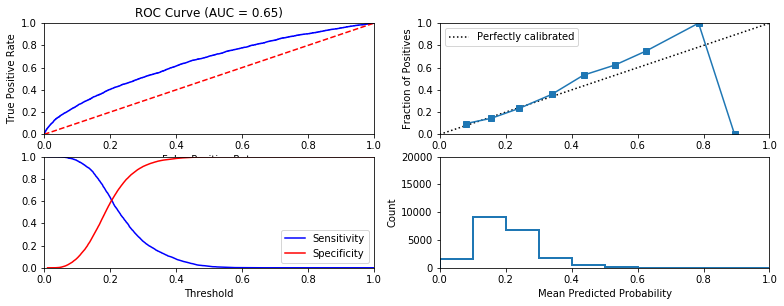


Similarity to LC grade ranking:  0.33330314891184754
Brier score: 0.1529192762419907
Were parameters on edge? : False
Score variations around CV search grid : 0.05438420348058304
[0.79673333 0.79673333 0.7968     0.7968     0.79643333 0.79636667
 0.79643333]


In [23]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'C':np.logspace(-3,3,7)}

l1_logistic = fit_classification(model=l1_logistic,data_dict=data_dict,cv_parameters=cv_parameters,model_name='L1 regularized Logistic Regression')

### $l_2$ regularized logistic regression

  Model: L2 regularized Logistic Regression
Fit time: 0.7 seconds
Optimal parameters:
{'C': 1.0}

Accuracy-maximizing threshold was: 0.4700392990135399
Accuracy:  0.79945
              precision    recall  f1-score   support

  No default     0.8027    0.9922    0.8875     15942
     Default     0.5797    0.0421    0.0786      4058

   micro avg     0.7994    0.7994    0.7994     20000
   macro avg     0.6912    0.5172    0.4830     20000
weighted avg     0.7575    0.7994    0.7234     20000



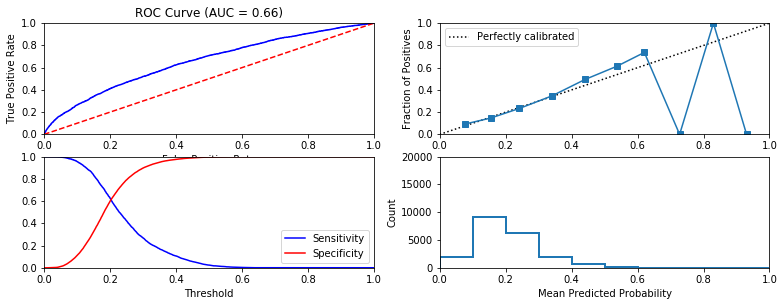


Similarity to LC grade ranking:  0.3342376784336775
Brier score: 0.15242969862071262
Were parameters on edge? : False
Score variations around CV search grid : 0.05438647868467794
[0.79673333 0.79673333 0.79673333 0.79676667 0.79633333 0.79633333
 0.79636667]


In [24]:
## Train and test a l_1 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C':np.logspace(-3,3,7)}

l2_logistic = fit_classification(model=l2_logistic,data_dict=data_dict,cv_parameters=cv_parameters,model_name='L2 regularized Logistic Regression')

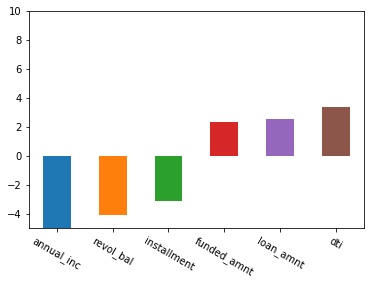

In [25]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision Tree
Fit time: 292.3 seconds
Optimal parameters:
{'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'min_samples_split': 26, 'splitter': 'random'}

Accuracy-maximizing threshold was: 0.6979166666666666
Accuracy:  0.7996
              precision    recall  f1-score   support

  No default     0.7996    0.9989    0.8882     15942
     Default     0.7976    0.0165    0.0324      4058

   micro avg     0.7996    0.7996    0.7996     20000
   macro avg     0.7986    0.5077    0.4603     20000
weighted avg     0.7992    0.7996    0.7146     20000



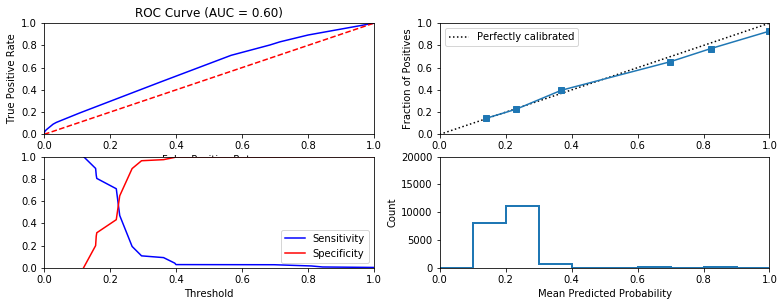


Similarity to LC grade ranking:  0.3248688837555211
Brier score: 0.15652405888198406
Were parameters on edge? : True
Score variations around CV search grid : 10.593660421253785
[0.80126667 0.79703333 0.79873333 ... 0.78093333 0.76106667 0.78256667]


In [26]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {'criterion':['gini','entropy'],'splitter':['best','random'],'max_depth':np.arange(3,20),'min_samples_split':list(range(2,50)),'max_features':['sqrt','log2',None]}

decision_tree = fit_classification(model=decision_tree,data_dict=data_dict,cv_parameters=cv_parameters,model_name='Decision Tree')

### Random forest

  Model: Random Forest
Fit time: 259.76 seconds
Optimal parameters:
{'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'min_samples_split': 8, 'n_estimators': 9}

Accuracy-maximizing threshold was: 0.7022539386348903
Accuracy:  0.80185
              precision    recall  f1-score   support

  No default     0.8018    0.9982    0.8893     15942
     Default     0.8146    0.0303    0.0584      4058

   micro avg     0.8018    0.8018    0.8018     20000
   macro avg     0.8082    0.5143    0.4739     20000
weighted avg     0.8044    0.8018    0.7207     20000



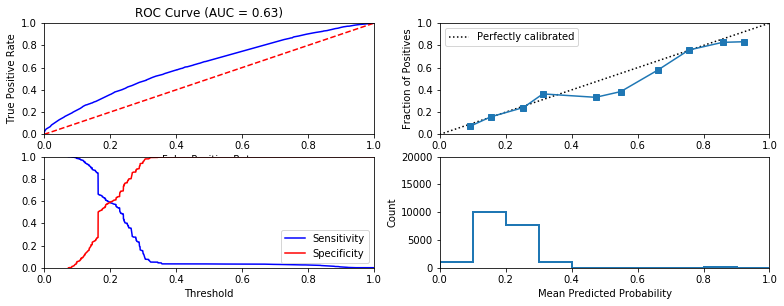


Similarity to LC grade ranking:  0.3252634450056819
Brier score: 0.1545394797264602
Were parameters on edge? : True
Score variations around CV search grid : 0.6565824468085213
[0.8015     0.80176667 0.80166667 ... 0.80076667 0.79983333 0.7997    ]


In [27]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier(n_jobs=-1)
cv_parameters = {'n_estimators':np.arange(5,10),'criterion':['gini','entropy'],'max_depth':np.arange(3,10),'min_samples_split':list(range(2,10)),'max_features':['sqrt','log2',None]}


random_forest = fit_classification(model=random_forest,data_dict=data_dict,cv_parameters=cv_parameters,model_name='Random Forest')

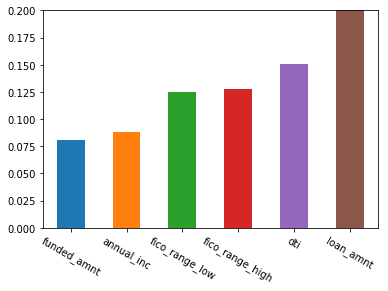

In [28]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

In [ ]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier()
cv_parameters = {'activation':['identity','logistic','tanh','relu'],'solver':['lbfgs','adam','sgd'],'alpha':10.0** -np.arange(1,5),'hidden_layer_sizes':np.arange(6,10),'learning_rate':['constant','invscaling','adaptive'],'max_iter':np.arange(200,1000,100)}

mlp = fit_classification(model=mlp,data_dict=data_dict,cv_parameters=cv_parameters,model_name='Multi-Layer Perceptron')

## Train and Test logistic regression model with features derived by LendingClub

798242
798242
798242
  Model: L1 Regularized Logistic Regression
Fit time: 0.05 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7971
              precision    recall  f1-score   support

  No default     0.7971    1.0000    0.8871     15942
     Default     0.0000    0.0000    0.0000      4058

   micro avg     0.7971    0.7971    0.7971     20000
   macro avg     0.3986    0.5000    0.4435     20000
weighted avg     0.6354    0.7971    0.7071     20000



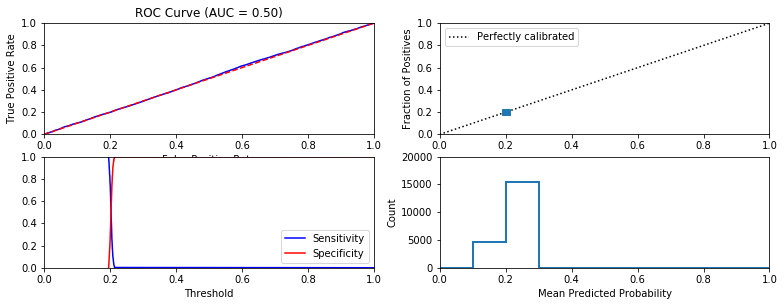


Similarity to LC grade ranking:  0.02349991175813151
Brier score: 0.1617285874752634
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.79673333]


In [29]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = 'int_rate'

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression(penalty='l1')

lc1_only_logistic = fit_classification(model=lc1_only_logistic,data_dict=data_dict,model_name='L1 Regularized Logistic Regression')

  Model: L2 Regularized Logistic Regression
Fit time: 0.03 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7971
              precision    recall  f1-score   support

  No default     0.7971    1.0000    0.8871     15942
     Default     0.0000    0.0000    0.0000      4058

   micro avg     0.7971    0.7971    0.7971     20000
   macro avg     0.3986    0.5000    0.4435     20000
weighted avg     0.6354    0.7971    0.7071     20000



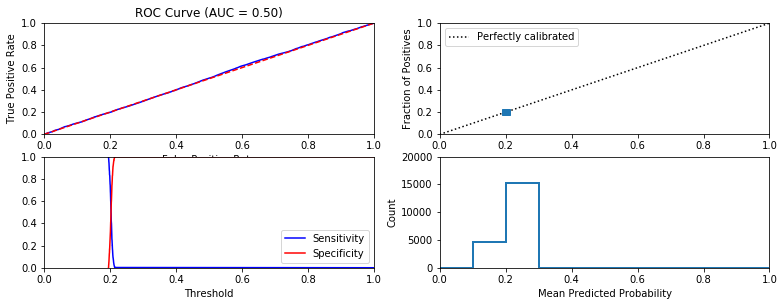


Similarity to LC grade ranking:  0.02349991175813151
Brier score: 0.16172906804372392
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.79673333]


In [30]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression(penalty='l2')

lc2_only_logistic = fit_classification(model=lc2_only_logistic,data_dict=data_dict,model_name='L2 Regularized Logistic Regression')

## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [78]:
lendingClub_features = ['int_rate','grade','installment','verification_status','sub_grade','dti','expDefaultRate','revol_util','sec_app_revol_util','ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb'
]
print(len(your_features))
print(len(lendingClub_features))

new_features = list(set(your_features) - set(lendingClub_features))

print(len(new_features))
data_dict_new = prepare_data(feature_subset = new_features)




117
13
109
[ True  True  True ...  True  True  True]
[False  True False ... False  True False]
798242
798242


  Model: Naive Bayes
Fit time: 0.05 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.8847792107125371
Accuracy:  0.80065
              precision    recall  f1-score   support

  No default     0.8015    0.9967    0.8885     15942
     Default     0.7029    0.0303    0.0581      4058

   micro avg     0.8006    0.8006    0.8006     20000
   macro avg     0.7522    0.5135    0.4733     20000
weighted avg     0.7815    0.8006    0.7200     20000



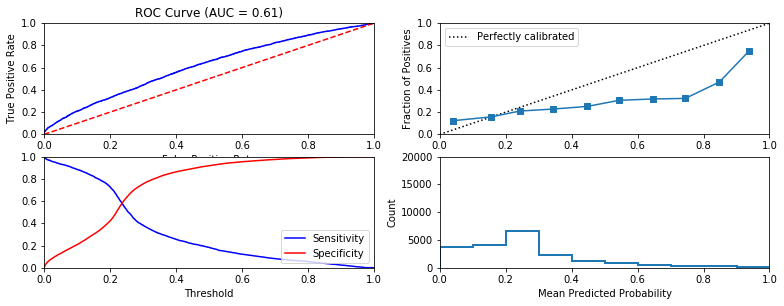


Similarity to LC grade ranking:  0.28512614985848705
Brier score: 0.17166270071978987
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.76363333]


In [32]:
#Naive Bayes
gnb2 = GaussianNB()
gnb2 = fit_classification(model=gnb2, data_dict=data_dict_new,
                          cv_parameters = {},
                          model_name = 'Naive Bayes')


  Model: L1 regularized Logistic Regression
Fit time: 2.05 seconds
Optimal parameters:
{'C': 0.001}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7971
              precision    recall  f1-score   support

  No default     0.7971    1.0000    0.8871     15942
     Default     0.0000    0.0000    0.0000      4058

   micro avg     0.7971    0.7971    0.7971     20000
   macro avg     0.3986    0.5000    0.4435     20000
weighted avg     0.6354    0.7971    0.7071     20000



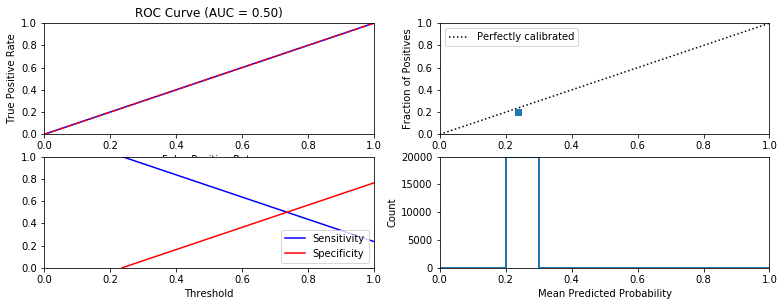


Similarity to LC grade ranking:  nan
Brier score: 0.16286728016105353
Were parameters on edge? : True
Score variations around CV search grid : 0.04183750313780813
[0.79673333 0.79673333 0.7964     0.7964     0.7965     0.79643333
 0.79643333]


In [33]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic2 = LogisticRegression(penalty='l1')
cv_parameters = {'C':np.logspace(-3,3,7)}

l1_logistic2 = fit_classification(model=l1_logistic2,data_dict=data_dict_new,cv_parameters=cv_parameters,model_name='L1 regularized Logistic Regression')

  Model: L2 regularized Logistic Regression
Fit time: 0.53 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.4118059902084067
Accuracy:  0.7995
              precision    recall  f1-score   support

  No default     0.8021    0.9937    0.8876     15942
     Default     0.5960    0.0367    0.0692      4058

   micro avg     0.7995    0.7995    0.7995     20000
   macro avg     0.6990    0.5152    0.4784     20000
weighted avg     0.7603    0.7995    0.7216     20000



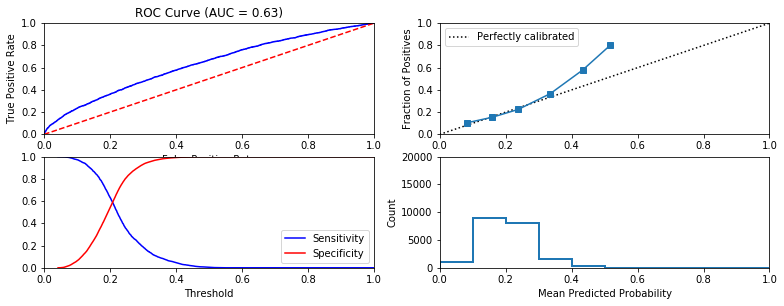


Similarity to LC grade ranking:  0.30258303019962546
Brier score: 0.1551786276154091
Were parameters on edge? : False
Score variations around CV search grid : 0.04183575283436765
[0.79673333 0.79673333 0.79676667 0.7966     0.79673333 0.79643333
 0.79646667]


In [34]:
## Train and test a l_1 regularized logistic regression classifier

l2_logistic2 = LogisticRegression(penalty='l2')
cv_parameters = {'C':np.logspace(-3,3,7)}

l2_logistic2 = fit_classification(model=l2_logistic2,data_dict=data_dict_new,cv_parameters=cv_parameters,model_name='L2 regularized Logistic Regression')

  Model: Decision Tree
Fit time: 259.7 seconds
Optimal parameters:
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 8, 'splitter': 'random'}

Accuracy-maximizing threshold was: 0.5476190476190477
Accuracy:  0.8018
              precision    recall  f1-score   support

  No default     0.8024    0.9968    0.8891     15942
     Default     0.7398    0.0357    0.0682      4058

   micro avg     0.8018    0.8018    0.8018     20000
   macro avg     0.7711    0.5163    0.4786     20000
weighted avg     0.7897    0.8018    0.7225     20000



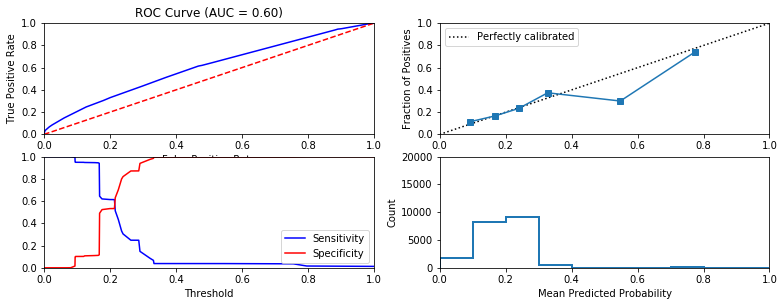


Similarity to LC grade ranking:  0.29089502750382695
Brier score: 0.1561552104198937
Were parameters on edge? : True
Score variations around CV search grid : 10.387075338483267
[0.80053333 0.79673333 0.80106667 ... 0.78126667 0.76493333 0.78476667]


In [35]:
## Train and test a decision tree classifier

decision_tree2 = DecisionTreeClassifier()
cv_parameters = {'criterion':['gini','entropy'],'splitter':['best','random'],'max_depth':np.arange(3,20),'min_samples_split':list(range(2,50)),'max_features':['sqrt','log2',None]}

decision_tree2 = fit_classification(model=decision_tree2,data_dict=data_dict_new,cv_parameters=cv_parameters,model_name='Decision Tree')

  Model: Random Forest
Fit time: 223.07 seconds
Optimal parameters:
{'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 7}

Accuracy-maximizing threshold was: 0.39396697719718604
Accuracy:  0.79945
              precision    recall  f1-score   support

  No default     0.8086    0.9805    0.8863     15942
     Default     0.5351    0.0882    0.1515      4058

   micro avg     0.7994    0.7994    0.7994     20000
   macro avg     0.6719    0.5344    0.5189     20000
weighted avg     0.7531    0.7994    0.7372     20000



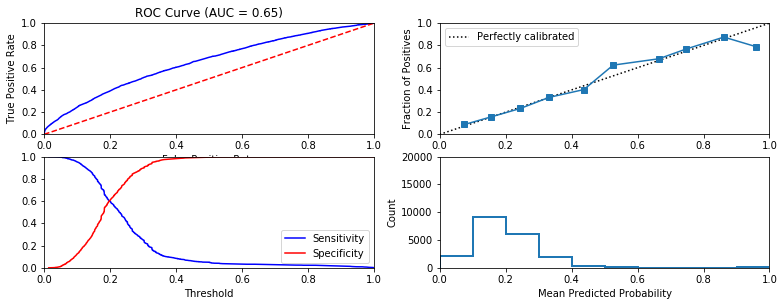


Similarity to LC grade ranking:  0.349682966293812
Brier score: 0.15265530393915697
Were parameters on edge? : True
Score variations around CV search grid : 0.6025348015790596
[0.8016     0.80186667 0.8019     ... 0.79996667 0.80063333 0.80116667]


In [36]:
## Train and test a random forest classifier

random_forest2 = RandomForestClassifier(n_jobs=-1)
cv_parameters = {'n_estimators':np.arange(5,10),'criterion':['gini','entropy'],'max_depth':np.arange(3,10),'min_samples_split':list(range(2,10)),'max_features':['sqrt','log2',None]}


random_forest2 = fit_classification(model=random_forest2,data_dict=data_dict_new,cv_parameters=cv_parameters,model_name='Random Forest')

  Model: Multi-Layer Perceptron
Fit time: 1074.95 seconds
Optimal parameters:
{'activation': 'identity', 'alpha': 0.1, 'hidden_layer_sizes': 6, 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'lbfgs'}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7971
              precision    recall  f1-score   support

  No default     0.7971    1.0000    0.8871     15942
     Default     0.0000    0.0000    0.0000      4058

   micro avg     0.7971    0.7971    0.7971     20000
   macro avg     0.3986    0.5000    0.4435     20000
weighted avg     0.6354    0.7971    0.7071     20000



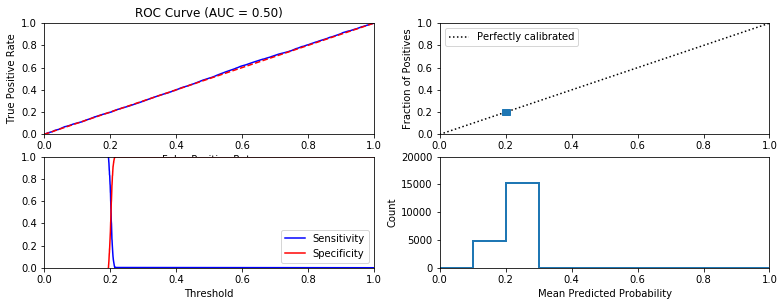


Similarity to LC grade ranking:  0.02349991175813151
Brier score: 0.16172947501080134
Were parameters on edge? : True
Score variations around CV search grid : 49.65693247426993
[0.79673333 0.79673333 0.79673333 ... 0.79673333 0.79673333 0.79673333]


In [47]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier()
cv_parameters = {'activation':['identity','logistic','tanh','relu'],'solver':['lbfgs','adam','sgd'],'alpha':10.0** -np.arange(1,5),'hidden_layer_sizes':np.arange(6,10),'learning_rate':['constant','invscaling','adaptive'],'max_iter':np.arange(200,1000,100)}

mlp = fit_classification(model=mlp,data_dict=data_dict,cv_parameters=cv_parameters,model_name='Multi-Layer Perceptron')